## CÓDIGO PARA ENCONTRAR LOS DIÁMETROS DE LOS OBJETOS PUNTUALES DE UNA IMAGEN FITS

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.utils.exceptions import AstropyUserWarning
from photutils.psf import extract_stars
from astropy.nddata import NDData
from astropy.table import QTable
from astropy.stats import  mad_std
from astropy.wcs import WCS
from photutils.aperture import CircularAperture
from photutils.detection import DAOStarFinder
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import pandas as pd
import warnings
from photutils.psf import IntegratedGaussianPRF
from astropy.table import QTable

warnings.filterwarnings("ignore")

In [140]:
# Open FITS file con astrometria
file_path = "111_Altair_v2.fits"
star_square_size = 9

Procesando archivo: 111_Altair_v2.fits
se encontraron 91 estrellas en total


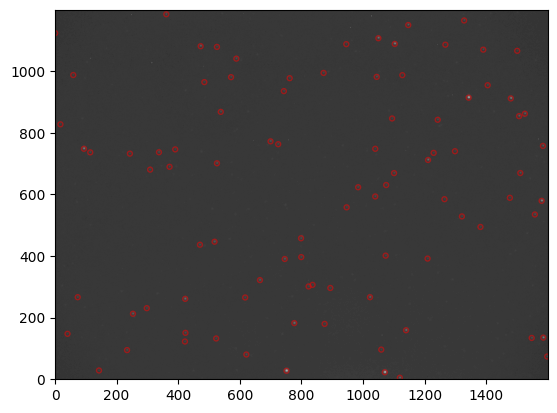

In [150]:
def find_star (file_path):
    print(f"Procesando archivo: {file_path}")

    # Cargar los datos de la imagen FITS
    hdul = fits.open(file_path)
    image_data = hdul[0].data
    header = hdul[0].header
    wcs = WCS(header)  

    # Calcular la desviación estándar (ruido de fondo) de la imagen
    std, median = mad_std(image_data), np.median(image_data)

    # Detectar estrellas utilizando DAOStarFinder
    # Ajusta el valor del FWHM (FWHM de la PSF estimada) y el threshold (umbral de detección)
    daofind = DAOStarFinder(fwhm=10.0, threshold=1.0 * median)
    stars = daofind(image_data- median)

    if stars is None:
        print("No se encontraron estrellas.")
        return None
    print(f"se encontraron {len(stars)} estrellas en total")

    # Coordenadas de las estrellas
    x_coords = stars["xcentroid"]
    y_coords = stars["ycentroid"]

    ## Visualizacion de las estrellas encontradas
    positions = np.transpose((stars["xcentroid"], stars["ycentroid"]))# coordenadas de las estrellas
    apertures = CircularAperture(positions, r=8.0)
    norm = ImageNormalize(stretch=SqrtStretch())
    plt.imshow(image_data, cmap="gray", origin="lower", norm=norm)
    apertures.plot(color="red", lw=1, alpha=0.5);
    plt.show()

    return x_coords, y_coords,image_data-median

x, y, image_data = find_star(file_path)
stars_find = QTable([x, y], names=('x', 'y'))

In [152]:
psf_model = IntegratedGaussianPRF(flux=1, sigma=2.7 / 2.35)
fit_shape = (21, 21)
finder = DAOStarFinder(6.0, 2.0)
psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder, aperture_radius=4)

init_params = QTable()

init_params['x'] = x

init_params['y'] = y

original_image = image_data.copy()

phot = psfphot(image_data, init_params=stars_find)

def minmax(data):
    scaler = MinMaxScaler()
    scaler.fit(data)
    return scaler.transform(data)

stars_tbl = Table()

stars_tbl['x'] = phot["x_fit"]

stars_tbl['y'] = phot["y_fit"]  

mean_val, median_val, std_val = sigma_clipped_stats(image_data, sigma=2.0)  
image_data = image_data.astype(np.float64) - median_val  
field_data = NDData(image_data)

psf_image = psfphot.make_model_image(image_data.shape, (9,9))
ns_psf_image = np.sqrt(minmax(psf_image))
psf_field_data = NDData(psf_image)

stars = extract_stars(field_data, stars_tbl, size=star_square_size)

In [153]:
def fxn(): #we enclose this procedure in a function for putting it in an ignoring deprecation class
    x_fwhm = []
    y_fwhm = []
    radii = []
    for i in range(len(stars)):
        # Generate fake data
        rng = np.random.default_rng(0)
        
        z = np.array(stars[i])
        y, x = np.mgrid[:z.shape[0], :z.shape[1]]
        
        
        p_init = models.Gaussian2D()
        fit_p = fitting.LevMarLSQFitter()
        with warnings.catch_warnings():
            # Ignore model linearity warning from the fitter
            warnings.filterwarnings('ignore', message='Model is linear in parameters',
                                    category=AstropyUserWarning)
            p = fit_p(p_init, x, y, z)
    
        nan = np.nan

        if p.x_fwhm < 1 or p.y_fwhm < 1:
            x_fwhm.append(nan) 
            y_fwhm.append(nan) 
            radii.append(nan)
        if p.x_fwhm > 50 or p.y_fwhm > 50:
            x_fwhm.append(nan) 
            y_fwhm.append(nan) 
            radii.append(nan)
        else:
            x_fwhm.append(p.x_fwhm) 
            y_fwhm.append(p.y_fwhm) 
            if p.x_fwhm < p.y_fwhm:
                radii.append(p.x_fwhm)
            else:
                radii.append(p.y_fwhm)
    
    x_fwhm = np.array(x_fwhm, dtype=np.float32)
    y_fwhm = np.array(y_fwhm, dtype=np.float32)
    radii = np.array(radii, dtype=np.float32)
    x_star = stars.center_flat[:,0]
    y_star = stars.center_flat[:,1]

    return x_star, y_star, x_fwhm, y_fwhm, radii


with warnings.catch_warnings(action="ignore"):
    x_star, y_star, x_fwhm, y_fwhm, radii = fxn()

print(f"Se procesaron: {len(x_star)} estrellas")
print("....")
nan = np.sum(np.isnan(x_fwhm))
print(f"No se pudieron determinar los radios de {nan}")

Se procesaron: 89 estrellas
....
No se pudieron determinar los radios de 32


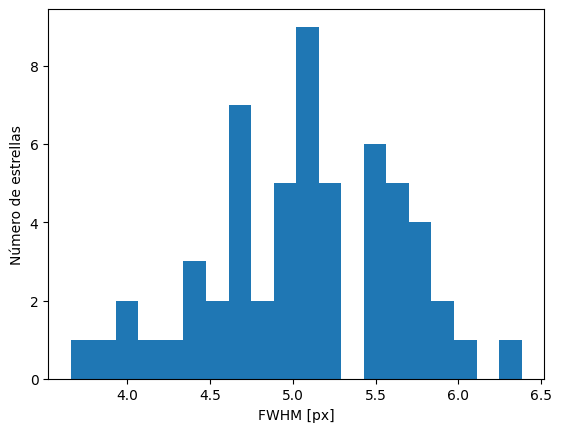

In [156]:
plt.hist(radii, bins=20)
plt.xlabel("FWHM [px]")
plt.ylabel("Número de estrellas")
plt.show()

In [157]:
from astropy.stats import mad_std

# Calcular la media y la desviación estándar del diametro
mean_d, median_d, std_d = np.nanmean(radii), np.nanmedian(radii), np.nanstd(radii)
print(f"Los parámetros estadísticos de los diámetros encontrados para {len(diameter)} estrellas  son:")
print("....")
print(f"Promedio: {mean_d:.2f}")
print("....")
print(f"Mediana: {median_d:.2f}")
print("....")
print(f"Desviación estandar: {std_d:.2f}")

Los parámetros estadísticos de los diámetros encontrados para 90 estrellas  son:
....
Promedio: 5.06
....
Mediana: 5.07
....
Desviación estandar: 0.59
